In [1]:
import mouseQPCRModelSelection 
import numpy as np
import time
import AssignGPGibbsSingleLoop
import GPflow
import numpy as np
import time
import cPickle as pickle
import assigngp_dense
from matplotlib import pyplot as plt
%matplotlib inline
import branch_kernParamGPflow as bk
import BranchingTree as bt


In [2]:
subsetSelection = 0

In [3]:
pt,Yall = mouseQPCRModelSelection.LoadMouseQPCRData(subsetSelection=subsetSelection)
Y = Yall[:,0][None].T
print 'Y'
print Y.shape
strExp = 'MouseQPCR_Exp1'
m,_ = mouseQPCRModelSelection.InitModels(pt,Y)

Loaded GPLVM data/guo_ssData.p with nrowsXncols = (437, 2).
LoadMouseQPCRData output
Y
(437, 1)
Branching kernel =====================
unnamed.branchkernelparam.\u001bBv\u001b transform:(none) prior:None
[[ 1.]]
unnamed.branchkernelparam.kern.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.kern.\u001blengthscales\u001b transform:+ve prior:None
[ 1.]
unnamed.white.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
Initialise models: MAP =====================
model.likelihood.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.\u001bBv\u001b transform:(none) prior:None
[[ 1.]]
model.kern.branchkernelparam.kern.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.kern.\u001blengthscales\u001b transform:+ve prior:None
[ 1.]
model.kern.white.\u001bvariance\u001b transform:+ve prior:None [FIXED]
[  1.00000000e-06]

Initialise models: VB =====================
compiling tensorflow function...
done


In [4]:
numMAPsteps = 10
D=Y.shape[1]
print D

1


('\riteration 1 bound=-17593.6020006 grad=1083.86536879, beta=0',)
('\riteration 2 bound=-17536.5318937 grad=1442.75182773, beta=2.32698747286',)
('\riteration 3 bound=-16997.8217654 grad=5434.43637865, beta=3.04177330386',)
('\riteration 4 bound=-12422.5633639 grad=75332.9667436, beta=4.12246560444',)
('\riteration 5 bound=-11146.9129297 grad=234031.969994, beta=1.26449557354',)
('\riteration 6 bound=-10512.6915107 grad=66903.9888344, beta=0.0',)
('\riteration 7 bound=-9645.78782767 grad=58563.1251934, beta=0.211358794793',)
('\riteration 8 bound=-7757.27571952 grad=83933.3562914, beta=1.61849740797',)
('\riteration 9 bound=-7018.64812194 grad=105985.238738, beta=0.0',)
('\riteration 10 bound=-6502.53561462 grad=63501.4372063, beta=0.0',)
('\riteration 12 bound=-5841.11653547 grad=57292.9194715, beta=10.774074158',)
('\riteration 13 bound=-4399.78538382 grad=96954.9105514, beta=2.28927163553',)
('\riteration 14 bound=-3826.82443487 grad=87027.9695778, beta=0.0',)
('\riteration 15 boun

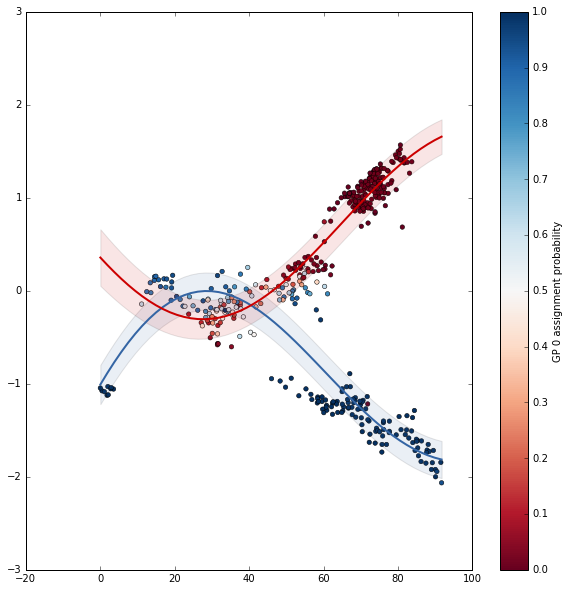

In [14]:
from GPclust import OMGP
m = OMGP(pt[:,None], Y, K=2, variance=0.01, prior_Z='DP') # use a truncated DP with K=2
m.rbf.lengthscale = 65
m.rbf_1.lengthscale = 65
m.optimize(step_length=0.01, maxiter=20)
fig=plt.figure(figsize=(10,10))
m.plot()

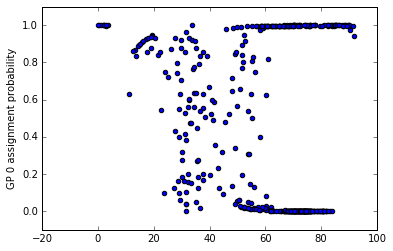

In [22]:
m.plot_probs()

In [23]:
m.phi.shape

(437, 2)

In [13]:
m

OMGP.,value,constraints,priors
variance,0.01,+ve,
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
rbf_1.variance,1.0,+ve,
rbf_1.lengthscale,1.0,+ve,


In [25]:
m.phi.sum(axis=1) # these are probabilities

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [60]:
def InitialisePhiFromOMGP(phiOMGP, b = 40.):     
    # branching location needed
    # create index
    N = Y.shape[0]
    assert phiOMGP.shape[0] == N
    assert phiOMGP.shape[1] == 2 # run OMGP with K=2 trajectories

    phiInitial = np.zeros((N, 3*N))
    # large neg number makes exact zeros, make smaller for added jitter
    phiInitial_invSoftmax = -9. * np.ones((N, 3*N))  
    XExpanded = np.zeros((3*D, 2))
    XExpanded[:] = np.nan
    #phiInitial[:] = np.nan
    eps = 1e-8
    iterC = 0
    for i,p in enumerate(pt):
        if(p <b): # before branching - we know for sure where it is
            phiInitial[i,iterC:iterC+3] = np.array([1-2*eps,0+eps,0+eps])
        else:
            phiInitial[i,iterC:iterC+3] = np.hstack([eps,phiOMGP[i,:]-eps])
        phiInitial_invSoftmax[i,iterC:iterC+3] = np.log(phiInitial[i,iterC:iterC+3] )
        
        XExpanded[i+iterC,i+iterC+3,0] = pt[i+iterC,i+iterC+3] 
        iterC += 3

    assert np.any(np.isnan(phiInitial)) == False, 'no nans plaase ' + str( np.nonzero(np.isnan(phiInitial)))
    assert np.any(phiInitial < 0) == False, 'no negatives plaase ' + str( np.nonzero(np.isnan(phiInitial)))
    assert np.any(np.isnan(XExpanded)) == False, 'no nans plaase in XExpanded ' 
    
    return phiInitial, phiInitial_invSoftmax, XExpanded

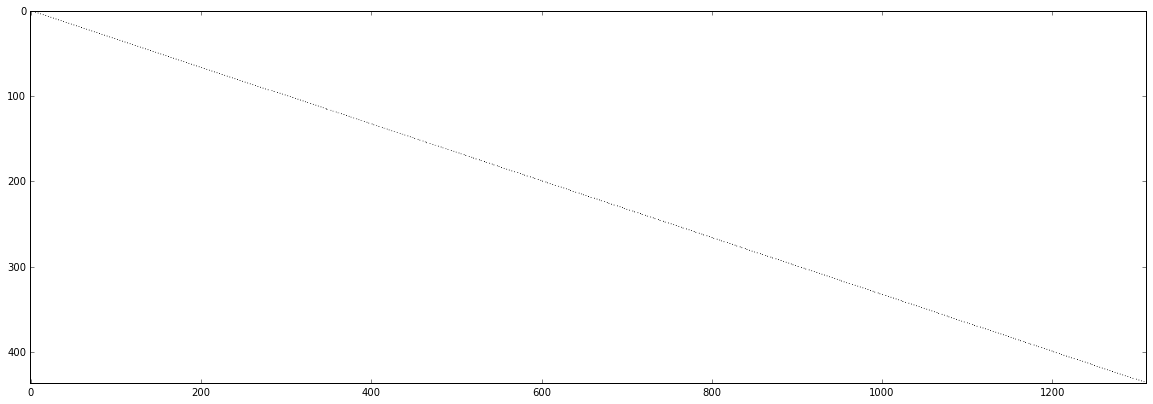

In [61]:
phiInitial, phiInitial_invSoftmax = InitialisePhiFromOMGP(phiOMGP=m.phi, b=40.)
fig=plt.figure(figsize=(20,20))
_=plt.imshow(phiInitial,cmap='Greys')

In [59]:
phiInitial.sum(axis=1)

array([ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.  

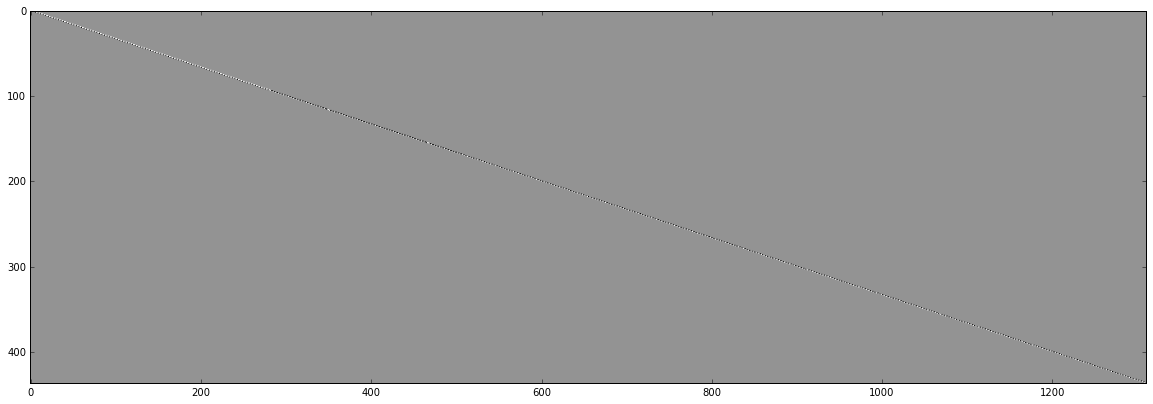

In [63]:
fig=plt.figure(figsize=(20,20))
_=plt.imshow(phiInitial_invSoftmax,cmap='Greys')